In [1]:
# Author : Akash K S
# Roll No : CS22MTECH11012

import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Fucntion to ceate data for the Adding problem

In [2]:
def create_data(N, seq_range):
  X = []
  # creating a placeholder for labels
  Y = torch.ones((N, 1))
  for i in range(N):
    # randomly choose a sequence length in given range for individual samples
    #seq_len = torch.randint(seq_range[0], seq_range[1], (1,))
    seq_len = np.random.randint(seq_range[0], seq_range[1])

    # create first row of sample with floating numbers from random.uniform
    X_1 = torch.rand(seq_len, 1)

    # creating place holders with zeros for 2nd row of sample
    X_2 = torch.zeros(seq_len, 1)

    # randomly choosing positions for placing ones
    positions = torch.randperm(seq_len)[:2]
    #positions = np.random.choice(seq_len, size=2, replace=False)
    X_2[positions] = 1

    # summing up the samples with ones and saving them to label Y
    Y[i, 0] = torch.sum(X_1[positions])

    # stacking both the rows of sample
    X_data = torch.hstack((X_1, X_2))
    X.append(X_data)

  # create a tensor from the list of tensors
  #X = torch.stack(X)
  return X, Y


### Generating training data along with nework dimensions

In [58]:
# generating training and testing data
X, Y = create_data(7500, [3, 20])
X_test, Y_test = create_data(750, [3, 20])

# defining the dimension to initalize weights
input_size = 2
hidden_size = 64 # taking randomly
output_size = 1 # no of classes is 1
epochs = 25

### function to train the model

In [67]:
# function to train the models. will be called individually for all the RNNs
def train_model(model, criteria, optimizer, X, Y, epochs, model_type):
  print("***************************************** {} ***********************************".format(model_type))
  train_loss = np.zeros(epochs)
  train_acc = np.zeros(epochs)
  for epoch in range(epochs):
    loss_tr = 0
    acc_tr = 0
    correct = 0
    error = 0.05 # error to check the correctness of predictions 
    for sample, label in zip(X, Y):
      #perform forward prop
      pred = model.forward(sample)

      # clear gradients of optimizer from prev step
      optimizer.zero_grad()

      #find loss using MSE Loss
      loss = criteria(pred, label)
      loss_tr = loss_tr + loss.item()
      
      # perfom back prop
      loss.backward(retain_graph=True)

      # update parameters after backprop
      optimizer.step()

      # if the difference is below error, count it as correct
      if abs(pred - label) <= error:
        correct += 1

    train_loss[epoch] = loss_tr / len(X)
    train_acc[epoch] = correct / len(X) * 100
    print("epoch {}, training loss = {:.4f}, training accuracy = {:.2f}".format(epoch+1, train_loss[epoch], train_acc[epoch]))
  return train_loss, train_acc

### function to test the model

In [68]:
#returns the mean of total loss of all test samples
def test_model(model, criteria, X_test, Y_test):
  # error in the difference between actual and predicted outputs
  error = 0.05
  loss_test = 0
  correct = 0
  i = 0
  for x, y in zip(X_test, Y_test):
    y_pred = model.forward(x)
    loss = criteria(y_pred, y)
    loss_test += loss.item()
    i += 1

    # if the difference is below error, count it as correct
    if abs(y_pred - y) <= error:
      correct += 1

  test_acc = correct/len(X_test) *100
  mean_test_loss = loss_test/len(X_test)
  print("test loss = {:.4f}, test acc = {:.2f} %".format(mean_test_loss, test_acc))

  test_list = [0, 10, 234, 351, 109, 490]
  for i in test_list:
    print("actual value = ", Y_test[i].item(), "pred value = ", model.forward(X_test[i]).item())
  return mean_test_loss

## Elmon RNN
### 1. Initilaizing the weights using Xavier initialization
### 2. Forward Prop using below RNN equations

$$ Hidden State : h_t = tanh(W_{xh}X_t + W_{hh}h_{t-1} + B_{hh}) $$
$$ Output : y_t = W_{hy}h_t + B_{hy} $$

In [61]:
# defining class for ElmonRNN
class RNN:
  def __init__(self, input_size, hidden_size, output_size):
    self.hidden_size = hidden_size
    # initailizing weights using Xavier Initialization
    self.Wxh = torch.randn(input_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(input_size)) # previously done xavier, but MSRA giving better performance
    self.Whh = torch.randn(hidden_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Why = torch.randn(hidden_size, output_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Wxh.requires_grad = True
    self.Whh.requires_grad = True
    self.Why.requires_grad = True
    self.Bhh = torch.zeros(hidden_size, 1, dtype=torch.float, requires_grad = True)
    self.Bhy = torch.zeros((output_size, 1), dtype=torch.float, requires_grad = True)

  def forward(self, X):
    #initializing the hidden state to zeros
    h_prev = torch.zeros((self.hidden_size, 1), dtype=torch.float, requires_grad = True)

    # find and update hidden state for every intance of sample X
    for seq, instance in enumerate(X):
      instance = torch.reshape(instance, (2,1))
      h_prev = torch.tanh(self.Wxh.T @ instance + self.Whh @ h_prev + self.Bhh)

    # find output with the last update hidden state
    pred = h_prev.T @ self.Why + self.Bhy
    pred.retain_grad()
    h_prev.retain_grad()
    return pred

  def parameters(self):
    return [self.Wxh, self.Whh, self.Why, self.Bhh, self.Bhy]

### LSTM
### 1. Initilaizing the weights using Xavier initialization
### 2. Forward Prop using below LSTM equations

$$ Forget Gate : f_t = sigmoid(W_{xf}X_t + W_{hf}h_{t-1} + B_{hf}) $$
$$ Input Gate : i_t = sigmoid(W_{xi}X_t + W_{hi}h_{t-1} + B_{hi}) $$
$$ c_t = tanh(W_{xc}X_t + W_{hc}h_{t-1} + B_{hc}) $$
$$ Cell State : C_t = f_t * C_{t-1} + i_t * c_t $$
$$ Output Gate : o_t = sigmoid(W_{xo}X_t + W_{ho}h_{t-1} + B_{ho}) $$
$$ Hidden State : h_t = o_t * tanh(C_t) $$
$$ Output : y_t = W_{hy}h_t + B_{hy} $$

In [62]:
class LSTM:
  def __init__(self, input_size, hidden_size, output_size):
    self.hidden_size = hidden_size
    # initailizing weights using Xavier Initialization
    self.Wxf = torch.randn(input_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(input_size))
    self.Whf = torch.randn(hidden_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Wxi = torch.randn(input_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(input_size))
    self.Whi = torch.randn(hidden_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Wxc = torch.randn(input_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(input_size))
    self.Whc = torch.randn(hidden_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Wxo = torch.randn(input_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(input_size))
    self.Who = torch.randn(hidden_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Why = torch.randn(hidden_size, output_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Wxf.requires_grad = True
    self.Whf.requires_grad = True
    self.Wxi.requires_grad = True
    self.Whi.requires_grad = True
    self.Wxc.requires_grad = True
    self.Whc.requires_grad = True
    self.Wxo.requires_grad = True
    self.Who.requires_grad = True
    self.Why.requires_grad = True
    self.Bhf = torch.zeros(hidden_size, 1, dtype=torch.float, requires_grad = True)
    self.Bhi = torch.zeros(hidden_size, 1, dtype=torch.float, requires_grad = True)
    self.Bhc = torch.zeros(hidden_size, 1, dtype=torch.float, requires_grad = True)
    self.Bho = torch.zeros(hidden_size, 1, dtype=torch.float, requires_grad = True)
    self.Bhy = torch.zeros((output_size, 1), dtype=torch.float, requires_grad = True)

  def forward(self, X):
    # initialize previous hidden state and cell state to zeros
    h_prev = torch.zeros((self.hidden_size, 1), dtype=torch.float, requires_grad = True)
    c_prev = torch.zeros((self.hidden_size, 1), dtype=torch.float, requires_grad = True)

    for seq, instance in enumerate(X):
      instance = torch.reshape(instance, (2,1))
      #forget gate
      ft = torch.sigmoid(self.Wxf.T @ instance + self.Whf @ h_prev + self.Bhf)

      #input gate
      it = torch.sigmoid(self.Wxi.T @ instance + self.Whi @ h_prev + self.Bhi)
      ct = torch.tanh(self.Wxc.T @ instance + self.Whc @ h_prev + self.Bhc)

      # output gate
      ot = torch.sigmoid(self.Wxo.T @ instance + self.Who @ h_prev + self.Bho)

      # selective erase and write the prev cell state
      c = ft * c_prev + it * ct

      # update the hidden state
      h = ot * torch.tanh(c)

      # making current state as prev state
      h_prev = h
      c_prev = c
    
    # finding the output using last hidden state
    pred = h_prev.T @ self.Why + self.Bhy

    pred.retain_grad()
    h_prev.retain_grad()
    c_prev.retain_grad()
    return pred
  
  def parameters(self):
    return [self.Wxf, self.Whf, self.Wxi, self.Whi,self.Wxc, self.Whc,self.Wxo, self.Who, self.Why, self.Bhf, self.Bhi, self.Bhc, self.Bho, self.Bhy]

## GRU
### 1. Initializing the weights using Xavier Initailization
### 2. Forward prop using below GRU equations

$$ r_t = sigmoid(W_{xr}X_t + W_{hr}h_{t-1} + B_{hr}) $$
$$ z_t = sigmoid(W_{xz}X_t + W_{hz}h_{t-1} + B_{hz}) $$
$$ h^1_t = tanh(W_{xh^1}X_t + W_{hh^1}h_{t-1} + B_{hh^1}) $$
$$ h_t = (1 - z_t) * h_{t-1} + z_t * h^1_t $$
$$ y_t = W_{hy}h_t + B_{hy} $$

In [63]:
class GRU:
  def __init__(self, input_size, hidden_size, output_size):
    self.hidden_size = hidden_size
    # initailizing weights using Xavier Initialization
    self.Wxr = torch.randn(input_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(input_size))
    self.Whr = torch.randn(hidden_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Wxz = torch.randn(input_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(input_size))
    self.Whz = torch.randn(hidden_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Wxh1 = torch.randn(input_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(input_size))
    self.Whh1 = torch.randn(hidden_size, hidden_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Why = torch.randn(hidden_size, output_size, dtype=torch.float)/torch.sqrt(torch.tensor(hidden_size))
    self.Wxr.requires_grad = True
    self.Whr.requires_grad = True
    self.Wxz.requires_grad = True
    self.Whz.requires_grad = True
    self.Wxh1.requires_grad = True
    self.Whh1.requires_grad = True
    self.Why.requires_grad = True
    self.Bhr = torch.zeros(hidden_size, 1, dtype=torch.float, requires_grad = True)
    self.Bhz = torch.zeros(hidden_size, 1, dtype=torch.float, requires_grad = True)
    self.Bhh1 = torch.zeros(hidden_size, 1, dtype=torch.float, requires_grad = True)
    self.Bhy = torch.zeros((output_size, 1), dtype=torch.float, requires_grad = True)

  def forward(self, X):
    # initialize previous hidden state to zeros
    h_prev = torch.zeros((self.hidden_size, 1), dtype=torch.float, requires_grad = True)

    for seq, instance in enumerate(X):
      instance = torch.reshape(instance, (2,1))

      zt = torch.sigmoid(self.Wxz.T @ instance + self.Whz @ h_prev + self.Bhz)

      rt = torch.sigmoid(self.Wxr.T @ instance + self.Whr @ h_prev + self.Bhr)

      h1 = torch.tanh(self.Wxh1.T @ instance + self. Whh1 @ (rt * h_prev) + self.Bhh1)

      #hidden state
      ht = (1-zt) * h_prev + zt * h1

      # making current state as prev state
      h_prev = ht
    
    pred = h_prev.T @ self.Why + self.Bhy

    pred.retain_grad()
    h_prev.retain_grad()
    return pred
  
  def parameters(self):
    return [self.Wxr, self.Whr, self.Wxz, self.Whz, self.Wxh1, self.Whh1, self.Why, self.Bhr, self.Bhz, self.Bhh1, self.Bhy]

### function for baseline comparison

In [74]:
def baseline_compare(rnn_loss, lstm_loss, gru_loss, Y_test):
  criterion = nn.MSELoss(reduction = 'mean')
  baseline = torch.ones(Y_test.shape[0])
  baseline_error = criterion(baseline, Y_test).item()
  print(baseline_error, rnn_loss, lstm_loss, gru_loss)

  # taking all the values and plotting a bar graph to visualize baseline comparison
  values = np.array((baseline_error, rnn_loss, lstm_loss, gru_loss))
  labels = ['Baseline', 'RNN', 'LSTM', 'GRU']

  plt.bar(labels, values)
  plt.title("Baseline Comparison")
  plt.xlabel('Various RNNs')
  plt.ylabel('Errors')
  plt.show()

### Driver Code

In [69]:
loss_fn = nn.MSELoss(reduction='mean')

# train and test rnn
rnn = RNN(input_size, hidden_size, output_size)
optimizer_rnn = optim.SGD(rnn.parameters(), lr=0.001)
rnn_train_loss, rnn_train_acc = train_model(rnn, loss_fn, optimizer_rnn, X, Y, epochs, "RNN")
rnn_test_loss = test_model(rnn, loss_fn, X_test, Y_test)

#train and test LSTM
lstm = LSTM(input_size, hidden_size, output_size)
optimizer_lstm = optim.SGD(lstm.parameters(), lr=0.001)
lstm_train_loss, lstm_train_acc = train_model(lstm, loss_fn, optimizer_lstm, X, Y, epochs, "LSTM")
lstm_test_loss = test_model(lstm, loss_fn, X_test, Y_test)

# train and test GRU
gru = GRU(input_size, hidden_size, output_size)
optimizer_gru = optim.SGD(gru.parameters(), lr=0.001)
gru_train_loss, gru_train_acc = train_model(gru, loss_fn, optimizer_gru, X, Y, epochs, "GRU")
gru_test_loss = test_model(gru, loss_fn, X_test, Y_test)

#baseline_compare(rnn_test_loss, lstm_test_loss, gru_test_loss, Y_test)

***************************************** RNN ***********************************
epoch 1, training loss = 0.1319, training accuracy = 10.87
epoch 2, training loss = 0.0368, training accuracy = 23.17
epoch 3, training loss = 0.0180, training accuracy = 31.68
epoch 4, training loss = 0.0122, training accuracy = 38.43
epoch 5, training loss = 0.0093, training accuracy = 43.09
epoch 6, training loss = 0.0076, training accuracy = 47.19
epoch 7, training loss = 0.0065, training accuracy = 49.87
epoch 8, training loss = 0.0058, training accuracy = 52.88
epoch 9, training loss = 0.0052, training accuracy = 55.19
epoch 10, training loss = 0.0047, training accuracy = 57.56
epoch 11, training loss = 0.0044, training accuracy = 59.61
epoch 12, training loss = 0.0040, training accuracy = 61.43
epoch 13, training loss = 0.0038, training accuracy = 62.84
epoch 14, training loss = 0.0035, training accuracy = 64.35
epoch 15, training loss = 0.0033, training accuracy = 65.48
epoch 16, training loss = 0

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([750, 1])) that is different to the input size (torch.Size([750])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TypeError: ignored

0.17860101163387299 0.001815021980728935 0.0010907100703139061 0.000900530561863216


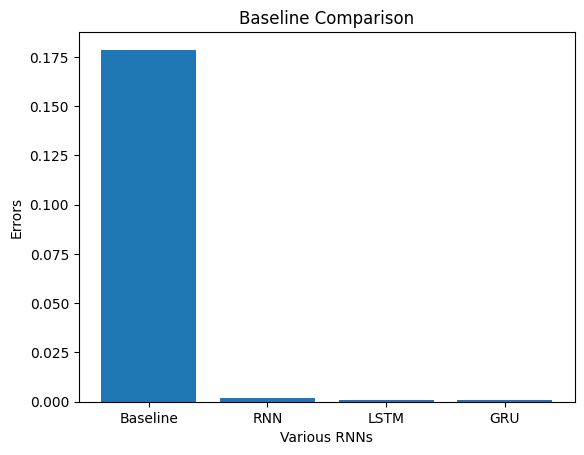

In [75]:
baseline_compare(rnn_test_loss, lstm_test_loss, gru_test_loss, Y_test)

### Visualizing learning curves. Both loss and accuracy

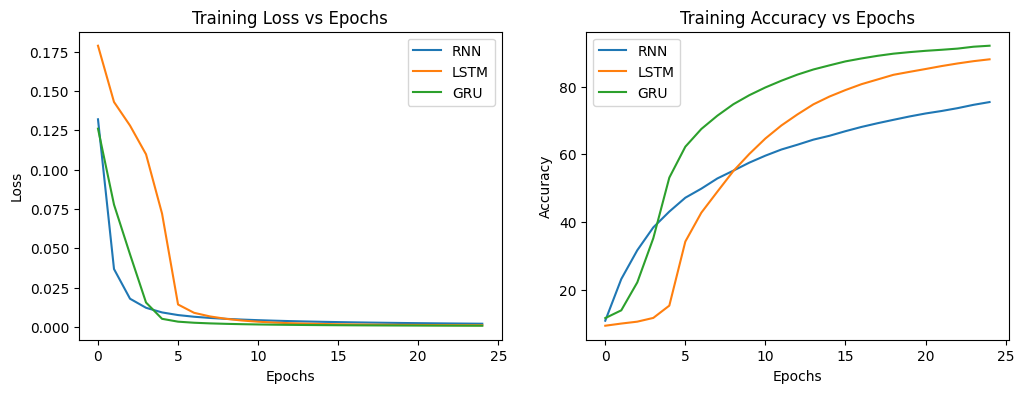

In [77]:
# create a figure with a 1x3 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# plot data on each subplot
axs[0].plot(rnn_train_loss, label = 'RNN')
axs[0].plot(lstm_train_loss, label = 'LSTM')
axs[0].plot(gru_train_loss, label = 'GRU')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title("Training Loss vs Epochs")

axs[1].plot(rnn_train_acc, label = 'RNN')
axs[1].plot(lstm_train_acc, label = 'LSTM')
axs[1].plot(gru_train_acc, label = 'GRU')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title("Training Accuracy vs Epochs")

# show the figure
plt.show()